In [1]:
# データの用意
import numpy as np
import pandas as pd
import seaborn as sns

df = sns.load_dataset("iris")  # irisのデータを取得
df.iloc[0, 1] = np.NaN  # わざと欠損値を作る

# データの表示
df.head()


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,NaN,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [2]:
# pandas-profilingのパッケージをインストール
!pip install pandas-profiling


# データのprofileを作成
import pandas_profiling as pdp
from IPython.display import HTML

profile = pdp.ProfileReport(df)
profile.to_file(outputfile="profile.html")
HTML(filename='profile.html')


/usr/local/lib/python3.6/dist-packages/pandas_profiling/plot.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 657, in launch_instance
    app.initialize(argv)
  File "<decorator-gen-121>", line 2, in initialize
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 87, in catch_config_error

Number of variables,5
Number of observations,150
Total Missing (%),0.1%
Total size in memory,5.9 KiB
Average record size in memory,40.5 B
Numeric,3
Categorical,1
Boolean,0
Date,0
Text (Unique),0
Rejected,1


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


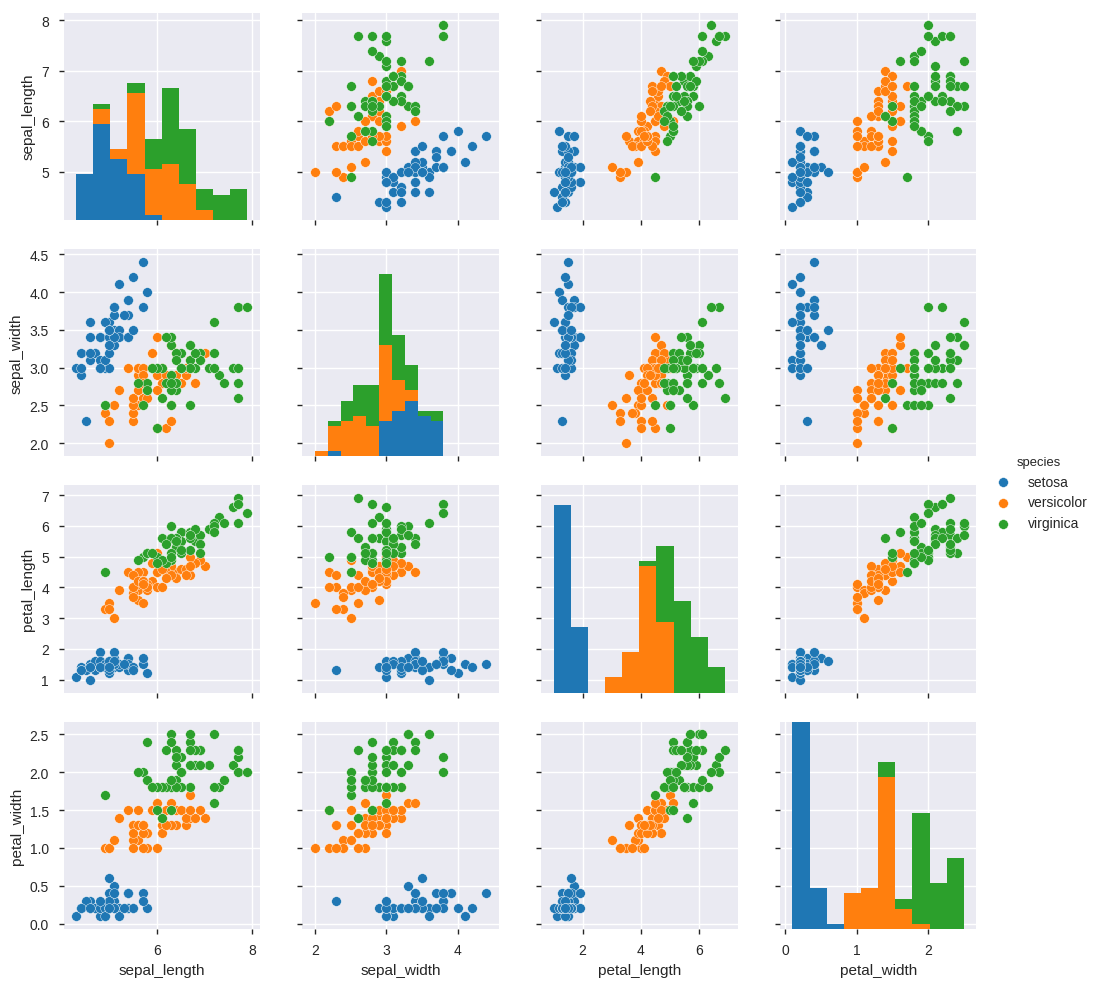

In [4]:
sns.pairplot(df, hue='species')


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


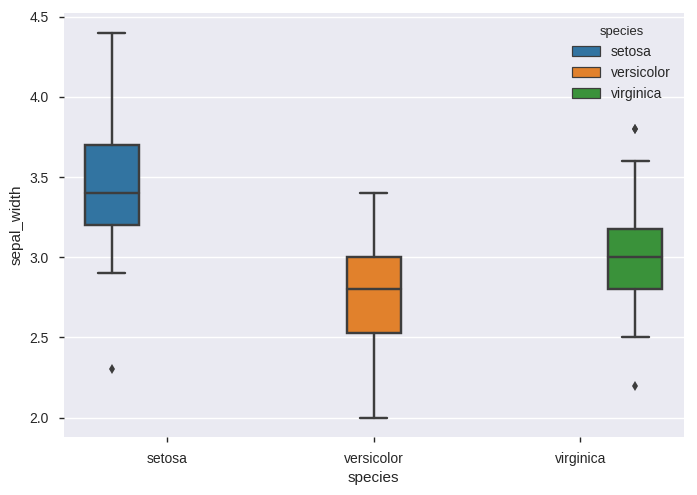

In [5]:
sns.boxplot(x='species', y='sepal_width', hue='species', data=df)


In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold


# 1. 前処理------
df = df.dropna()  # 欠損値のあるレコードを削除
del df['petal_width']  # データチェックの結果からpetal_lengthと相関が強いpetal_widthは削除

# カテゴリーデータであるspecies（種類）を数値データに変換
df['species'] = df['species'].map(
    {'setosa': 0, 'versicolor': 1, 'virginica': 2})

# Numpyの変数を用意
y = np.array(df['species'])
X = np.array(df.iloc[:, 0:3])  # 0, 1, 2行目の3つを取得


# 2. 入れ子式の交差検証法を行う用意
# 2.1 outer loopの設定
outer_loop = KFold(n_splits=5, shuffle=True, random_state=0)

# 2.2 inner loopの設定
inner_loop = KFold(n_splits=4, shuffle=True, random_state=0)

# 2.3 パイプライン生成
pipe = Pipeline([('scaler', StandardScaler()),
                 ('logistic', LogisticRegression())])

# 2.4 グリッドサーチの設定
# 比較するハイパーパラメータ設定
param_grid = {
    'logistic__C': [1, 10, 100],
}

gs = GridSearchCV(
    estimator=pipe, param_grid=param_grid, scoring='accuracy', cv=inner_loop)


# 3. 学習
val_result = np.zeros((5, 3))  # outer_loop数×ハイパーパラメータの種類
ol_index = 0  # outer_loopのindex

# outer loop
for train_val_index, test_index in outer_loop.split(X):
    X_train_val, X_test = X[train_val_index], X[test_index]
    y_train_val, y_test = y[train_val_index], y[test_index]

    # inner loop
    gs.fit(X_train_val, y_train_val)  # trainで学習し、valで評価
    val_result[ol_index] = gs.cv_results_["mean_test_score"]

    print(" outer loopの結果その{}：{}".format(ol_index+1,
                                         val_result[ol_index]))
    ol_index += 1


# 4. 評価
print("--\n outer loopの平均結果 ：{}\n--".format(val_result.mean(axis=0)))
# 出力すると3番目のハイパーパラメータ C=100が良いと分かる


# 5. テストデータで性能確認
clf_pipe = Pipeline([('scaler', StandardScaler()),
                     ('logistic', LogisticRegression(C=100))])
il_index = 0  # inner-loopのindex
test_result = np.zeros(5*4)  # outer_loop数×inner_loop数

# outer loop
for train_val_index, test_index in outer_loop.split(X):
    X_train_val, X_test = X[train_val_index], X[test_index]
    y_train_val, y_test = y[train_val_index], y[test_index]

    # inner loop
    for train_index, val_index in inner_loop.split(X_train_val):
        X_train, X_val = X_train_val[train_index], X_train_val[val_index]
        y_train, y_val = y_train_val[train_index], y_train_val[val_index]

        clf_pipe.fit(X_train, y_train)  # trainで学習し
        test_result[il_index] = clf_pipe.score(X_test, y_test)  # testの正解率を求める

        print(" inner loopの結果その{}：{}".format(il_index +
                                             1, test_result[il_index]))
        il_index += 1

print("--\n テストデータの平均正解率：{}".format(test_result.mean()))


 outer loopの結果その1：[0.85714286 0.89915966 0.92436975]
 outer loopの結果その2：[0.80672269 0.88235294 0.94957983]
 outer loopの結果その3：[0.86554622 0.89915966 0.94117647]
 outer loopの結果その4：[0.84033613 0.88235294 0.90756303]
 outer loopの結果その5：[0.83333333 0.90833333 0.95      ]
--
 outer loopの平均結果 ：[0.84061625 0.89427171 0.93453782]
--
 inner loopの結果その1：0.9
 inner loopの結果その2：0.9
 inner loopの結果その3：0.9333333333333333
 inner loopの結果その4：0.9666666666666667
 inner loopの結果その5：0.8666666666666667
 inner loopの結果その6：0.9
 inner loopの結果その7：0.9
 inner loopの結果その8：0.8666666666666667
 inner loopの結果その9：0.9
 inner loopの結果その10：0.8666666666666667
 inner loopの結果その11：0.8666666666666667
 inner loopの結果その12：0.9333333333333333
 inner loopの結果その13：0.9333333333333333
 inner loopの結果その14：1.0
 inner loopの結果その15：1.0
 inner loopの結果その16：1.0
 inner loopの結果その17：0.9310344827586207
 inner loopの結果その18：0.9655172413793104
 inner loopの結果その19：0.9655172413793104
 inner loopの結果その20：0.9655172413793104
--
 テストデータの平均正解率：0.9280459770114943
